# Detekcija i rešavanje osmosmerke

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 30, 20

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_to_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return image_bin

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

# dobavljanje povrsine unutar okvira osmosmerke
def get_frame_area(contours):
    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))
    areas.sort()
    return areas[-2]

# selektovanje i vraćanje okvira osmosmerke
def select_frame(image_color, image_bin, contours):
    frame_area = get_frame_area(contours)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour) 
        if area == frame_area:
            region = image_bin[y:y+h+1, x:x+w+1]             
            cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 2)
            return image_color, (x, y, h)
    
# selektovanje regiona oko slova zadatih reči
def select_letters(image_color, image_bin, contours, frame, in_frame):
    sorted_regions = [] 
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour) # area se računa kako bi izbacili šumove
        if area > 150 and h < 100 and h > 30:# and w > 20 area>100:
            # frame[0] je x koordinata gornjeg levog ćoška frame-a, frame[1] je y koordinata, a frame[2] je visina frame-a
            if in_frame and x > frame[0] and y > frame[1] and y < frame[1] + frame[2]: 
                region = image_bin[y:y+h+1, x:x+w+1]             
                regions_array.append([resize_region(region), (x, y, w, h)]) 
                cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 0, 255), 2)
            elif not in_frame and (x < frame[0] or y > frame[1] + frame[2]):
                region = image_bin[y:y+h+1, x:x+w+1]             
                regions_array.append([resize_region(region), (x, y, w, h)]) 
                cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujućih pravougaonika
    # izračunati rastojanja između svih susednih regiona po x-osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
        region_distances.append(distance)
    
    return image_color, sorted_regions, region_distances

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

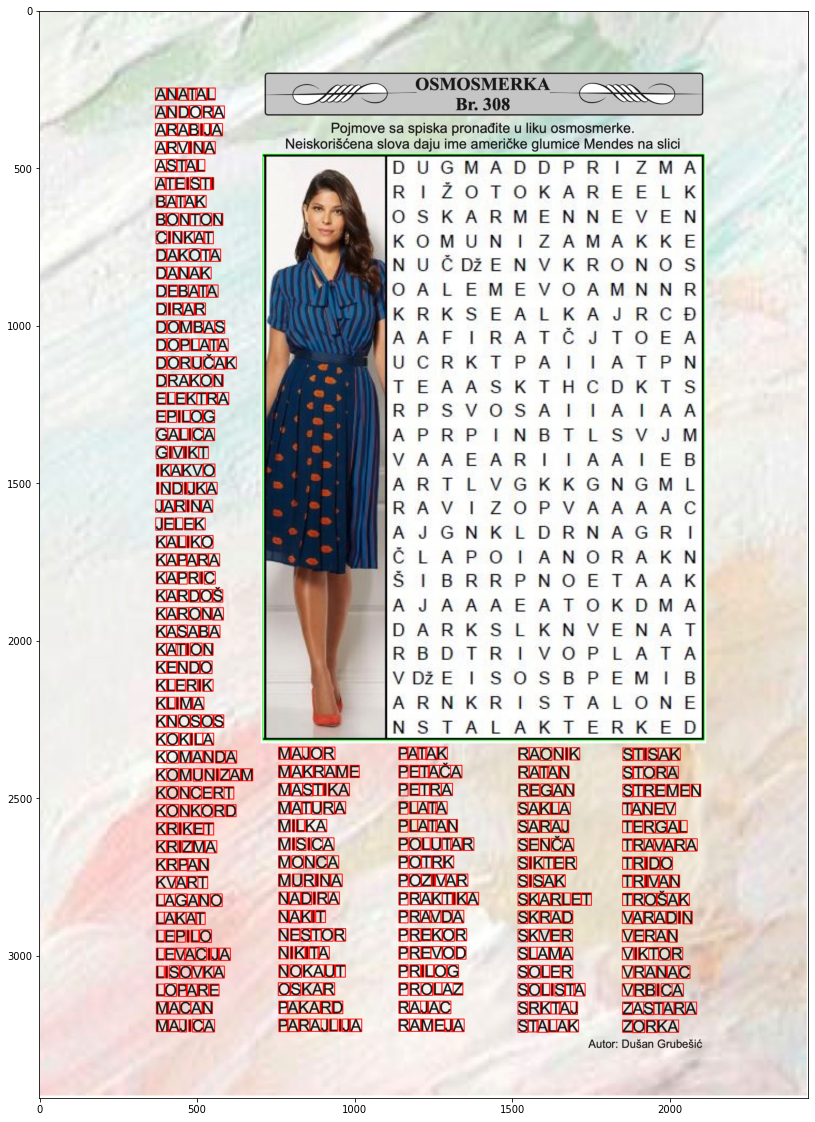

In [5]:
image_color = load_image('data/308vx - 01.jpg')
img = image_to_bin(image_to_gray(image_color))
image_edges = cv2.Canny(img, 255/3, 255)
kernel = np.ones((1, 1), np.uint8)
opening = cv2.morphologyEx(image_edges, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
img = image_smoothening(img)
image_bin = cv2.bitwise_or(img, closing)

contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

selected_frame, frame = select_frame(image_color.copy(), image_bin, contours)

selected_letters, letters, distances = select_letters(selected_frame, image_bin, contours, frame, False) 
display_image(selected_letters)